# Importing Libraries

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Loading Dataset

---
**The Oxford-IIIT Pet Dataset:** https://academictorrents.com/details/b18bbd9ba03d50b0f7f479acc9f4228a408cecc1

They have created a 37 category pet dataset with roughly 200 images for each class. 

---
**Attributes:**
* **Image**: filename

* **ID:** 1-37 Class ids

* **SPECIES:** 1 : Cat, 2 : Dog

* **BREED:** 1-25 : Cat, 1-12 : Dog
---

All images with 1st letter as **captial** are cat images, those with **small first letter** are dog images


> We download the compressed folders `images` and `annotations`. They are placed in the path `/root/.keras/datasets/`

In [19]:
input_dir = keras.utils.get_file('images', origin='http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz', untar=True)
keras.utils.get_file('annotations', origin='http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz', untar=True)

'/root/.keras/datasets/annotations'

In [20]:
os.chdir(input_dir)
os.chdir('../')

Importing the data of the image dataset

In [21]:
input_data = pd.read_csv('./annotations/list.txt', delimiter=' ', names=['Image', 'CLASS ID', 'SPECIES', 'BREED'], skiprows=6)
input_data

Image  CLASS ID  SPECIES  BREED
0           Abyssinian_100         1        1      1
1           Abyssinian_101         1        1      1
2           Abyssinian_102         1        1      1
3           Abyssinian_103         1        1      1
4           Abyssinian_104         1        1      1
...                    ...       ...      ...    ...
7344  yorkshire_terrier_96        37        2     25
7345  yorkshire_terrier_97        37        2     25
7346  yorkshire_terrier_98        37        2     25
7347  yorkshire_terrier_99        37        2     25
7348   yorkshire_terrier_9        37        2     25

[7349 rows x 4 columns]

Adding the filename extension `'.jpg'` to the image names in the dataframe

In [22]:
for i in range(len(input_data)):
  input_data.iloc[i,0] += '.jpg'

We turn the IDs into names for further use in the notebook

In [23]:
species_names = ['cat','dog']

In [24]:
breed_names = []
for i in range(len(input_data)):
  breed_name = '_'.join(input_data.iloc[i,0].split('_')[:-1])
  if breed_name not in breed_names:
    breed_names.append(breed_name)
breed_names

['Abyssinian',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'boxer',
 'British_Shorthair',
 'chihuahua',
 'Egyptian_Mau',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'Maine_Coon',
 'miniature_pinscher',
 'newfoundland',
 'Persian',
 'pomeranian',
 'pug',
 'Ragdoll',
 'Russian_Blue',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'Siamese',
 'Sphynx',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

Replacing `SPECIES` labels by `breed_names`

In [25]:
for i in range(len(input_data)):
  if input_data.iloc[i,2] == 1:
    input_data.iloc[i,2] = 'cat'
  elif input_data.iloc[i,2] == 2:
    input_data.iloc[i,2] = 'dog'

Replacing `BREED` labels by `breed_names`

In [26]:
for i in range(len(input_data)):
  breed_id = input_data.iloc[i,1]
  input_data.iloc[i,3] = breed_names[breed_id-1]

Here is our dataframe

In [27]:
input_data

Image  CLASS ID SPECIES              BREED
0           Abyssinian_100.jpg         1     cat         Abyssinian
1           Abyssinian_101.jpg         1     cat         Abyssinian
2           Abyssinian_102.jpg         1     cat         Abyssinian
3           Abyssinian_103.jpg         1     cat         Abyssinian
4           Abyssinian_104.jpg         1     cat         Abyssinian
...                        ...       ...     ...                ...
7344  yorkshire_terrier_96.jpg        37     dog  yorkshire_terrier
7345  yorkshire_terrier_97.jpg        37     dog  yorkshire_terrier
7346  yorkshire_terrier_98.jpg        37     dog  yorkshire_terrier
7347  yorkshire_terrier_99.jpg        37     dog  yorkshire_terrier
7348   yorkshire_terrier_9.jpg        37     dog  yorkshire_terrier

[7349 rows x 4 columns]

# Cat/Dog Classification 

## Preprocessing the data

Splitting into test, validation and test set

In [28]:
# Select 95% of the data as the train set
train_data = input_data.sample(frac=0.8, random_state=42)

# Select 20% of the remaining data as the validation set
val_data = input_data.drop(train_data.index).sample(frac=0.8, random_state=42)

# Select the remaining data as the test set
test_data = input_data.drop(train_data.index).drop(val_data.index)

Creating a test and a train `ImageDataGenerator` from the dataset `input_data` which contains an array of 2-tuples of `(batches of images, encoded labels)`

In [29]:
#Parameters
img_size = (224,224)    
channels=3
color_mode='rgb'
shuffle=True,
seed=123
class_mode='sparse'
batch_size=32
class_labels=species_names

#ImageDataGenerator which is going in the model with parameters for data augmentation
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,          # Range for data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255,              # Normalization of the rgb scale from [0,255] to [0,1]
    )
                                 
#Training set
train_gen = gen.flow_from_dataframe(
    train_data, input_dir, x_col='Image', y_col='SPECIES', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size
    )
#Validation set
val_gen = gen.flow_from_dataframe(
    val_data, input_dir, x_col='Image', y_col='SPECIES', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size
    )
#Test set
test_gen = gen.flow_from_dataframe(
    test_data, input_dir, x_col='Image', y_col='SPECIES', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, shuffle=False
    )

Found 5879 validated image filenames belonging to 2 classes.
Found 1176 validated image filenames belonging to 2 classes.
Found 294 validated image filenames belonging to 2 classes.


In [30]:
shape = train_gen.__getitem__(0)[0].shape[1:]

### Visualizing data

Let's visualize the augmented data we have got

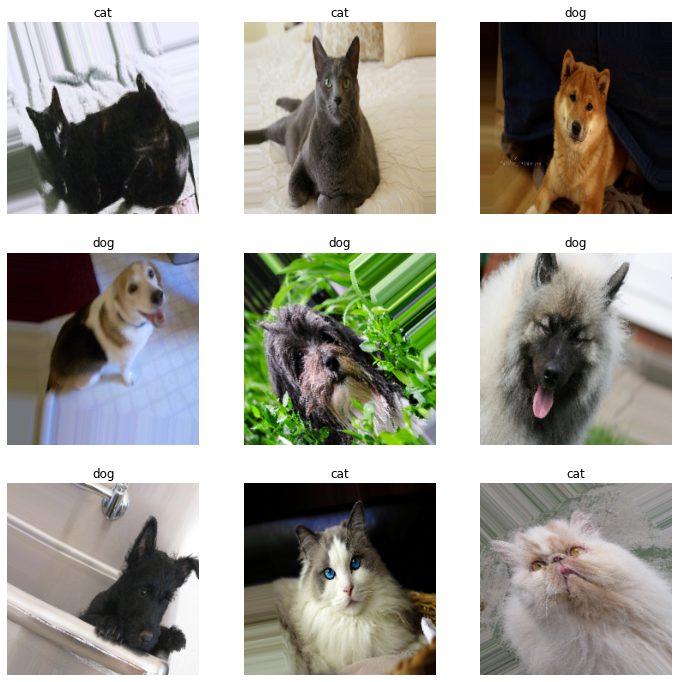

In [31]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_gen.__getitem__(0)[0][i])
    plt.title(class_labels[int(train_gen.__getitem__(0)[1][i])])
    plt.axis("off")

## Training of a CNN Model

We will use a Vanilla CNN Model for the classification.

In [32]:
model = keras.models.Sequential(name="vanilla_cnn", layers=[

# Add the convolutional layers
    layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

# Add the fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_labels), activation='softmax')
])

In [33]:
model.summary()

Model: "vanilla_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)       

In [34]:
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

history = model.fit(train_gen,
                    epochs=10,
                    callbacks = [keras.callbacks.ModelCheckpoint("species_classification.keras", save_best_only=True)], #Saves the best model
                    validation_data = val_gen)

Epoch 1/10
184/184 [==============================] - 269s 1s/step - loss: 0.6170 - accuracy: 0.6705 - val_loss: 0.6125 - val_accuracy: 0.6803
Epoch 2/10
184/184 [==============================] - 266s 1s/step - loss: 0.5925 - accuracy: 0.6855 - val_loss: 0.5731 - val_accuracy: 0.6837
Epoch 3/10
184/184 [==============================] - 261s 1s/step - loss: 0.5692 - accuracy: 0.6960 - val_loss: 0.5516 - val_accuracy: 0.7049
Epoch 4/10
184/184 [==============================] - 263s 1s/step - loss: 0.5617 - accuracy: 0.7098 - val_loss: 0.5424 - val_accuracy: 0.7287
Epoch 5/10
184/184 [==============================] - 265s 1s/step - loss: 0.5377 - accuracy: 0.7348 - val_loss: 0.5449 - val_accuracy: 0.7100
Epoch 6/10
184/184 [==============================] - 268s 1s/step - loss: 0.5277 - accuracy: 0.7398 - val_loss: 0.5287 - val_accuracy: 0.7338
Epoch 7/10
184/184 [==============================] - 262s 1s/step - loss: 0.5256 - accuracy: 0.7307 - val_loss: 0.5364 - val_accuracy: 0.7253

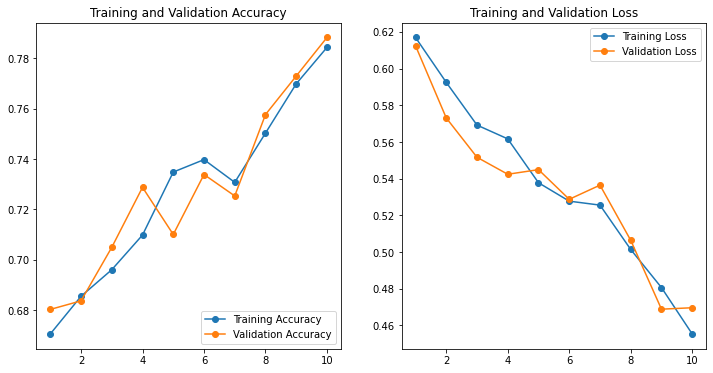

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(history.history["loss"]) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by small margins. We observe the validation accuracy increases with the training accuracy but with some gap at epoch 4 and epoch 8. The model has achieved around 78% accuracy on the validation set which is good but not perfect.

## Predict on new data

We saved the "best model" during the training

In [36]:
model = keras.models.load_model('./species_classification.keras')
class_labels = species_names

In [37]:
def predict(pet):
    path = './images/'+pet
    img = keras.utils.load_img(path, target_size=img_size)
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    plt.imshow(keras.utils.load_img(path))
    plt.axis('off')
    print("Pet: "+pet+" ("+input_data[input_data['Image']==pet].iloc[0,2]+")")
    print(
        "The model predicts the image is probably of a '{}' with a {:.3f}% confidence."
        .format(class_labels[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 164ms/step
Pet: great_pyrenees_155.jpg (dog)
The model predicts the image is probably of a 'dog' with a 73.106% confidence.


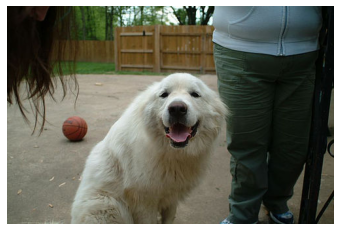

In [38]:
pet = input_data.sample(1).iloc[0,0]
predict(pet)

In [39]:
reals = pd.Series(test_gen.classes, name='reals')
predictions = model.predict(test_gen)
preds = pd.Series([np.argmax(predictions.round()[i]) for i in range(len(predictions))], name='preds')
reals.index=preds.index
pd.crosstab(preds, reals)

10/10 [==============================] - 7s 641ms/step


reals   0    1
preds         
0      26   13
1      74  181

# Breed Classification

Let's classify cat and dog breeds.

## Preprocessing the data

In [40]:
class_labels = breed_names

Creating a test and a train `ImageDataGenerator` from the dataset `input_data`

In [41]:
#Parameters
img_size = (224,224)   
channels=3
color_mode='rgb'
shuffle=True,
seed=123
class_mode='categorical'
batch_size=32

#ImageDataGenerator which is going in the model with parameters for data augmentation
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,          # Range for data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255,              # Normalization of the rgb scale from [0,255] to [0,1]
    validation_split=0.2        # Spliting into traint and validation set by a 80:20 proportion
    )
#Training set
train_gen = gen.flow_from_dataframe(
    input_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='training'
    )
#Test set
val_gen = gen.flow_from_dataframe(
    input_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='validation'
    )

Found 5880 validated image filenames belonging to 37 classes.
Found 1469 validated image filenames belonging to 37 classes.


Returns an `ImageDataGenerator` object. Access to the data is done in an array of 2-tuples of `(batches of images, encoded labels)`

In [42]:
shape = train_gen.__getitem__(0)[0].shape[1:]

Let's visualize the augmented data we have got

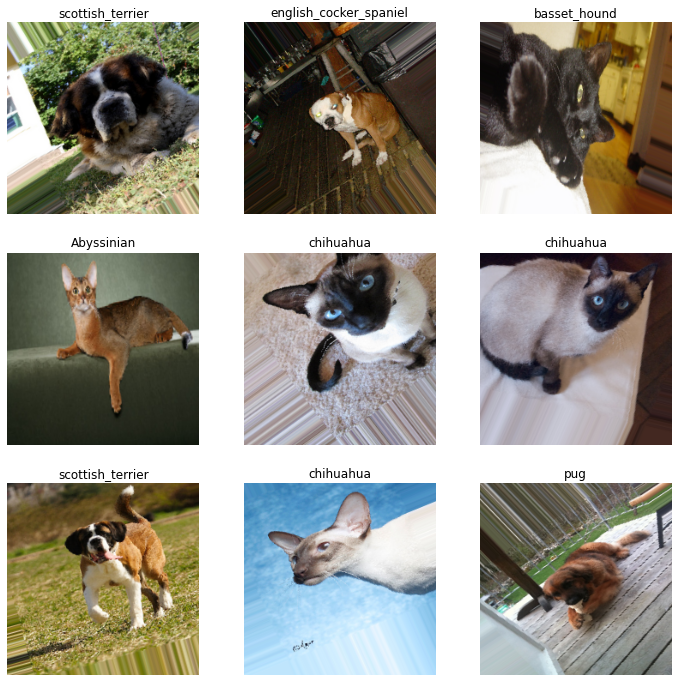

In [43]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_gen.__getitem__(0)[0][i])
    plt.title(class_labels[np.argmax(train_gen.__getitem__(0)[1][i])])
    plt.axis("off")

## Training the CNN Model

We choose the same model as before.

In [44]:
# Vanilla CNN
model = tf.keras.models.Sequential([
    # Add the convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Add the fully-connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Add the output layer
    layers.Dense(len(class_labels), activation='softmax')
])

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)      0

In [46]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen,
                    epochs=10,
                    callbacks = [keras.callbacks.ModelCheckpoint("breed_classification.keras", save_best_only=True)],
                    validation_data = val_gen)

Epoch 1/10
184/184 [==============================] - 464s 3s/step - loss: 3.6092 - accuracy: 0.0276 - val_loss: 3.6371 - val_accuracy: 0.0000e+00
Epoch 2/10
184/184 [==============================] - 466s 3s/step - loss: 3.6069 - accuracy: 0.0321 - val_loss: 3.6480 - val_accuracy: 0.0000e+00
Epoch 3/10
184/184 [==============================] - 460s 2s/step - loss: 3.6059 - accuracy: 0.0321 - val_loss: 3.6533 - val_accuracy: 0.0000e+00
Epoch 4/10
184/184 [==============================] - 457s 2s/step - loss: 3.6019 - accuracy: 0.0310 - val_loss: 3.6581 - val_accuracy: 0.0000e+00
Epoch 5/10
184/184 [==============================] - 461s 3s/step - loss: 3.5935 - accuracy: 0.0303 - val_loss: 3.6373 - val_accuracy: 0.0061
Epoch 6/10
184/184 [==============================] - 462s 3s/step - loss: 3.5326 - accuracy: 0.0466 - val_loss: 3.5843 - val_accuracy: 0.0374
Epoch 7/10
184/184 [==============================] - 459s 2s/step - loss: 3.4993 - accuracy: 0.0531 - val_loss: 3.5748 - val_

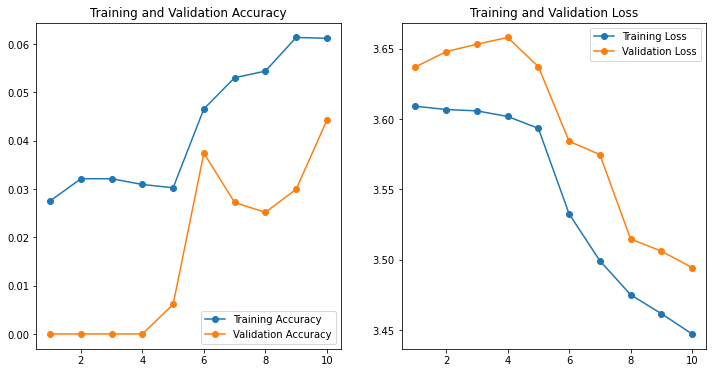

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are tiny. The model has achieved only around 4% accuracy on the validation set, and 6% on the training set.

In the plots above, although le curves increase over time, the learninng curve encounters some peak at epoch 6 and decrease back a bit after. It appears the model is insufficient for breed classification.

We'll see later an approach distinguishing cat breeds and dogs breeds.

## Predict on new data

In [48]:
model = keras.models.load_model('./breed_classification.keras')
class_labels = breed_names

In [49]:
def predict(pet):
  path ='./images/'+pet
  img = keras.utils.load_img(path, target_size=img_size)
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  plt.imshow(keras.utils.load_img(path))
  plt.axis('off')
  print('Breed: '+pet)
  print(
      "This image most likely belongs to that of a {} with a {:.2f}% confidence."
      .format(class_labels[np.argmax(score)], 100 * np.max(score))
  )

We try to predict the breed of a random pet

1/1 [==============================] - 0s 102ms/step
Breed: Siamese_145.jpg
This image most likely belongs to that of a staffordshire_bull_terrier with a 7.02% confidence.


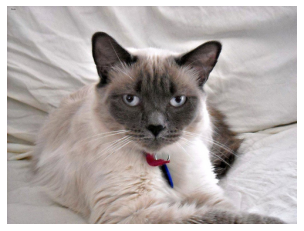

In [50]:
pet = input_data.sample(1).iloc[0,0]
predict(pet)

As we can see the confidence rate is around 3% which is really low. With 37 classes, it can be difficult to classify the breeds. Let's try to split the classification between cat and dog in order to achieve better prediction performance.

# Cat Breed Classification

Let's classify cat breeds.

## Preprocessing the data

Keep only cats

In [51]:
cat_data = input_data.loc[input_data['SPECIES']=='cat']
class_labels = cat_data['BREED'].unique()

Creating a test and a train `ImageDataGenerator` from the dataset `cat_data`

In [52]:
#Parameters
img_size = (224,224)   
channels=3
color_mode='rgb'
shuffle=True,
seed=123
class_mode='categorical'
batch_size=32

#ImageDataGenerator which is going in the model with parameters for data augmentation
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,          # Range for data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255,              # Normalization of the rgb scale from [0,255] to [0,1]
    validation_split=0.2        # Spliting into traint and validation set by a 80:20 proportion
    )
#Training set
train_gen = gen.flow_from_dataframe(
    cat_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='training'
    )
#Test set
val_gen = gen.flow_from_dataframe(
    cat_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='validation'
    )

Found 1897 validated image filenames belonging to 12 classes.
Found 474 validated image filenames belonging to 12 classes.


Returns an `ImageDataGenerator` object. Access to the data is done in an array of 2-tuples of `(batches of images, encoded labels)`

In [53]:
shape = train_gen.__getitem__(0)[0].shape[1:]

Let's visualize the augmented data we have got

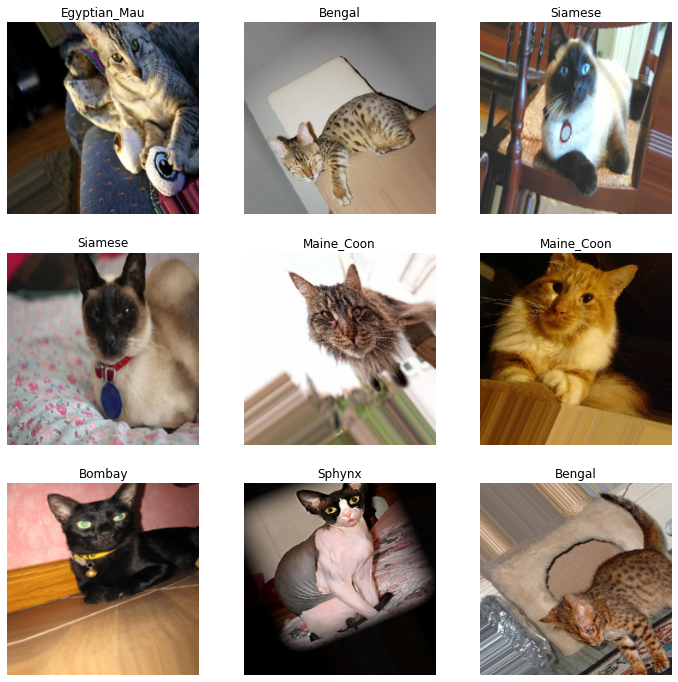

In [54]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_gen.__getitem__(0)[0][i])
    plt.title(class_labels[np.argmax(train_gen.__getitem__(0)[1][i])])
    plt.axis("off")

## Training the CNN Model

We choose the same model as before.

In [55]:
# Vanilla CNN
model = tf.keras.models.Sequential([
    # Add the convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Add the fully-connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Add the output layer
    layers.Dense(len(class_labels), activation='softmax')
])

In [56]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 128)     

In [57]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen,
                    epochs=10,
                    callbacks = [keras.callbacks.ModelCheckpoint("catbreed_classification.keras", save_best_only=True)],
                    validation_data = val_gen)

Epoch 1/10
60/60 [==============================] - 168s 3s/step - loss: 2.4839 - accuracy: 0.0965 - val_loss: 2.5060 - val_accuracy: 0.0000e+00
Epoch 2/10
60/60 [==============================] - 168s 3s/step - loss: 2.4820 - accuracy: 0.1091 - val_loss: 2.4980 - val_accuracy: 0.0000e+00
Epoch 3/10
60/60 [==============================] - 188s 3s/step - loss: 2.4398 - accuracy: 0.1381 - val_loss: 2.3786 - val_accuracy: 0.1203
Epoch 4/10
60/60 [==============================] - 168s 3s/step - loss: 2.3857 - accuracy: 0.1334 - val_loss: 2.3689 - val_accuracy: 0.1392
Epoch 5/10
60/60 [==============================] - 165s 3s/step - loss: 2.3314 - accuracy: 0.1450 - val_loss: 2.2822 - val_accuracy: 0.1477
Epoch 6/10
60/60 [==============================] - 167s 3s/step - loss: 2.2982 - accuracy: 0.1829 - val_loss: 2.2819 - val_accuracy: 0.1793
Epoch 7/10
60/60 [==============================] - 169s 3s/step - loss: 2.2737 - accuracy: 0.2045 - val_loss: 2.1979 - val_accuracy: 0.1983
Epoch

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are better. This time, the model has achieve nearly 23% accuracy.
This is clearly imperfect but it is a better start than the previous model.

## Predict on new data

In [59]:
model = keras.models.load_model('./catbreed_classification.keras')
class_labels = cat_data['BREED'].unique()

In [60]:
def predict(cat):
  path ='./images/'+cat
  img = keras.utils.load_img(path, target_size=img_size)
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  plt.imshow(keras.utils.load_img(path))
  plt.axis('off')
  print('Cat breed: '+cat)
  print(
      "This image most likely belongs to that of a {} with a {:.2f}% confidence."
      .format(class_labels[np.argmax(score)], 100 * np.max(score))
  )

We try to predict the breed of a random cat

1/1 [==============================] - 0s 106ms/step
Cat breed: Bombay_132.jpg
This image most likely belongs to that of a Bombay with a 19.80% confidence.


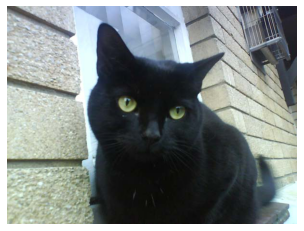

In [61]:
cat = cat_data.sample(1).iloc[0,0]
predict(cat)

Although it may predict sometimes the good breed, with 19% confidence only, the model can't be reliable to predict cat breeds.

# Dog Breed Classification

Let's classify dog breeds.

## Preprocessing the data

Keep only dogs

In [62]:
dog_data = input_data.loc[input_data['SPECIES']=='dog']
class_labels = dog_data['BREED'].unique()

Creating a test and a train `ImageDataGenerator` from the dataset `dog_data`

In [63]:
#Parameters
img_size = (224,224)   
channels=3
color_mode='rgb'
shuffle=True,
seed=123
class_mode='categorical'
batch_size=32

#ImageDataGenerator which is going in the model with parameters for data augmentation
gen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,          # Range for data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1/255,              # Normalization of the rgb scale from [0,255] to [0,1]
    validation_split=0.2        # Spliting into traint and validation set by a 80:20 proportion
    )
#Training set
train_gen = gen.flow_from_dataframe(
    dog_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='training'
    )
#Test set
val_gen = gen.flow_from_dataframe(
    dog_data, input_dir, x_col='Image', y_col='BREED', target_size=img_size, color_mode=color_mode,
    class_labels=class_labels, class_mode=class_mode, batch_size=batch_size, seed=seed, subset='validation'
    )

Found 3983 validated image filenames belonging to 25 classes.
Found 995 validated image filenames belonging to 25 classes.


Returns an `ImageDataGenerator` object. Access to the data is done in an array of 2-tuples of `(batches of images, encoded labels)`

In [64]:
shape = train_gen.__getitem__(0)[0].shape[1:]

Let's visualize the data we have got

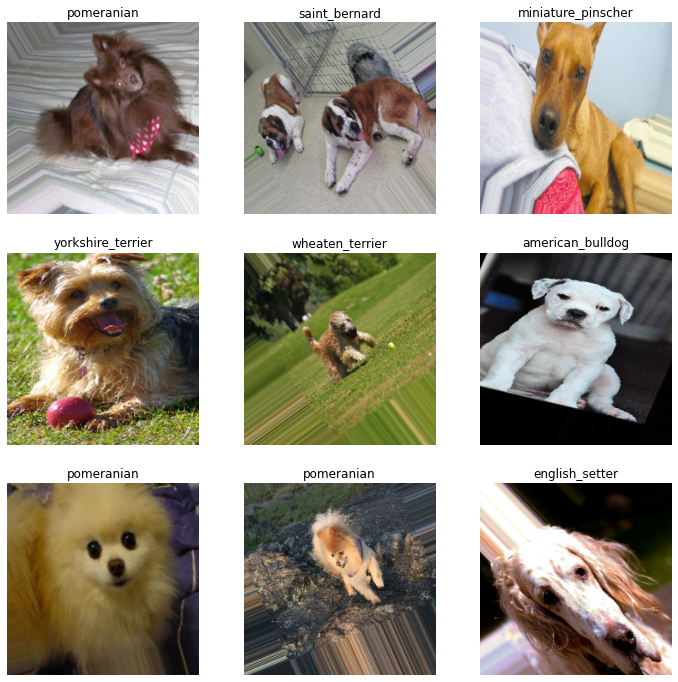

In [65]:
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_gen.__getitem__(0)[0][i])
    plt.title(class_labels[np.argmax(train_gen.__getitem__(0)[1][i])])
    plt.axis("off")

## Training the CNN Model

In [66]:
# Vanilla CNN
model = tf.keras.models.Sequential([
    # Add the convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Add the fully-connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),

    # Add the output layer
    layers.Dense(len(class_labels), activation='softmax')
])

In [67]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 26, 26, 128)     

In [68]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
history = model.fit(train_gen,
                    epochs=10,
                    callbacks = [keras.callbacks.ModelCheckpoint("dogbreed_classification.keras", save_best_only=True)],
                    validation_data = val_gen)

Epoch 1/10
125/125 [==============================] - 350s 3s/step - loss: 3.2200 - accuracy: 0.0414 - val_loss: 3.2250 - val_accuracy: 0.0060
Epoch 2/10
125/125 [==============================] - 340s 3s/step - loss: 3.1970 - accuracy: 0.0550 - val_loss: 3.2303 - val_accuracy: 0.0000e+00
Epoch 3/10
125/125 [==============================] - 343s 3s/step - loss: 3.1386 - accuracy: 0.0645 - val_loss: 3.3039 - val_accuracy: 0.0040
Epoch 4/10
125/125 [==============================] - 345s 3s/step - loss: 3.0931 - accuracy: 0.0758 - val_loss: 3.1495 - val_accuracy: 0.0422
Epoch 5/10
125/125 [==============================] - 349s 3s/step - loss: 3.0611 - accuracy: 0.0803 - val_loss: 3.1286 - val_accuracy: 0.0271
Epoch 6/10
125/125 [==============================] - 341s 3s/step - loss: 3.0454 - accuracy: 0.0856 - val_loss: 3.1003 - val_accuracy: 0.0090
Epoch 7/10
125/125 [==============================] - 338s 3s/step - loss: 3.0213 - accuracy: 0.0901 - val_loss: 3.1976 - val_accuracy: 0.

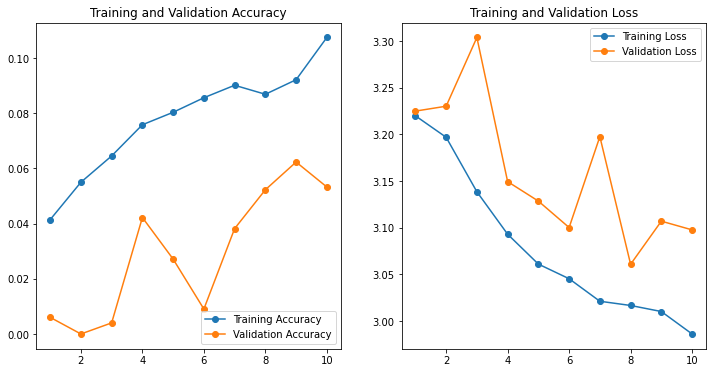

In [69]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model is less good than the cat model. It only achieve 10% accuracy for training and 5% accuracy for validation.

## Predict on new data

In [70]:
model = keras.models.load_model('./dogbreed_classification.keras')
class_labels = breed_names

In [71]:
def predict(dog):
  path ='./images/'+dog
  img = keras.utils.load_img(path, target_size=img_size)
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])
  plt.imshow(keras.utils.load_img(path))
  plt.axis('off')
  print('Dog breed: '+dog)
  print(
      "This image most likely belongs to that of a {} with a {:.2f}% confidence."
      .format(class_labels[np.argmax(score)], 100 * np.max(score))
  )

We try to predict the breed of a random dog

1/1 [==============================] - 0s 130ms/step
Dog breed: saint_bernard_88.jpg
This image most likely belongs to that of a pomeranian with a 10.17% confidence.


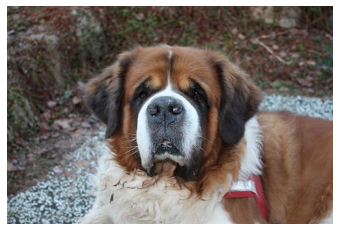

In [72]:
dog = dog_data.sample(1).iloc[0,0]
predict(dog)